# __Training and tuning the neural network__
- Dataset: Guarujá Municipality - São Paulo - Brazil
- Part 2/3

## Authorship:
        Caio Azevedo
        São Paulo University, February, 2024

## Main goals:

- Data processing for neural network application:
   - Removal of irrelevant features.
   - Normalization of the dataset.
   - ANN training and testing dataset split.

- Training and evaluation of neural networks:
   - Custom neural network implementation.
   - Keras neural network implementation.
   
- Automation of hyperparameter setup for improved performance (criterion: accuracy).
   - Brute force for optimizing hyperparameters in the custom network.
   - Keras Tuning for optimizing Keras hyperparameters (see .ipynb file).
   
- Neural network performance assessment with and without 'less important features'.

## Coding

### Imported libraries

In [1]:
import datetime
start = datetime.datetime.now()

In [2]:
import Rede_Neural as rna
from Rede_Neural import NeuralNetwork
from Rede_Neural import Layer

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, sys
import seaborn as sns

from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

from utils import plot

%matplotlib inline

In [3]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix

APP_PATH = os.getcwd()

### Auxiliary functions

In [4]:
#A chart that relates each of the features with the predicted value.
def plotSwarmChart(dataSet):
    dataSet['dummy'] = 0 # dummy feature to be used as a visual reference

    f, axes = plt.subplots(1, 7, figsize=(35, 17), sharex=False)
    f.subplots_adjust(hspace=0.2, wspace=0.7)
    
    sns.catplot(x=dataSet.columns[6], y='score', kind="swarm", hue='score', data=dataSet,ax=axes[6])
    
    for i in range(7):
        col = dataSet.columns[i] 
        ax = sns.swarmplot(x=dataSet['dummy'],y=dataSet[col].values,hue=(dataSet['score']>0.5),ax=axes[i])
        ax.set_title(col)
        
    plt.close(2)
    plt.close(3)
    plt.show()

In [5]:
def NetworkPerformance(y_real, y_prob):
    y_predict = (y_prob > 0.5)
    # accuracy: (tp + tn) / (p + n)
    accuracy = accuracy_score(y_real, y_predict)
    print('Accuracy: %f' % accuracy)
    # precision tp / (tp + fp)
    precision = precision_score(y_real, y_predict)
    print('Precision: %f' % precision)
    # recall: tp / (tp + fn)
    recall = recall_score(y_real, y_predict)
    print('Recall: %f' % recall)
    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(y_real, y_predict)
    print('F1 score: %f' % f1)
    # kappa
    kappa = cohen_kappa_score(y_real, y_predict)
    print('Cohens kappa: %f' % kappa)
    # ROC AUC
    auc = roc_auc_score(y_real, y_prob)
    print('ROC AUC: %f' % auc)
    # confusion matrix
    matrix = confusion_matrix(y_real, y_predict)
    print(matrix)

In [6]:
def printAUROC(y_real,y_predict):
    ns_auc = roc_auc_score(y_real, y_predict)
    # summarize scores
    print('AUC ROC=%.4f' % (ns_auc))
    # calculate roc curves
    lr_fpr, lr_tpr, _ = roc_curve(y_real, y_predict)
    random_probs = [0 for i in range(len(y_test))]
    p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)
    # plot the roc curve for the model
    plt.plot(p_fpr, p_tpr, linestyle='--', label='random', color='orange')
    pyplot.plot(lr_fpr, lr_tpr, marker='.', label='ANN', color='blue')
    
    # axis labels
    pyplot.xlabel('false positive rate')
    pyplot.ylabel('true positive rate')
    # show the legend
    pyplot.legend()
    # show the plot
    pyplot.show()

In [7]:
# split data into training, validation and testing sets
def dataPreparation(dataSet):
    X = dataSet.drop('class',axis=1)
    y= dataSet['class']
    
    X = X.to_numpy()    #converts dataframe into array to be used at NN
    y = y.to_numpy()    #converts dataframe into array to be used at NN
    y = y.reshape(-1,1) #reorganiza o array em um array 1 x 1
    
    # split data into training, validation and testing sets
    seed = 7
    test_size = 0.30
    
    train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=test_size, shuffle=False)
    train_x, val_x, train_y, val_y   = train_test_split(train_x,train_y, test_size=test_size, shuffle=False)

    # define the scaler
    scaler = MinMaxScaler(feature_range=(-1, 1)) 
    #scaler = MinMaxScaler() 
    # fit on the training dataset
    scaler.fit(train_x)
    # scale the training dataset
    train_x = scaler.transform(train_x)
    # scale the test dataset
    test_x = scaler.transform(test_x)
    # scale the test dataset
    val_x = scaler.transform(val_x)
    return train_x, test_x, val_x, train_y, test_y, val_y

In [8]:
def bubble_chart(data, col_2_buble_size, col_x, col_y):
    fig, ax = plt.subplots(figsize=(15,13))
    sizes = data[col_2_buble_size]*10
    scatter = ax.scatter(data[col_x], data[col_y], 
           c=(dataset['class']), cmap='rainbow', alpha=0.5,
           s=sizes, edgecolors='none')

    legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="landslide")

    ax.title.set_text("{}{}".format(len(data.index), ' landslides samples')) 

    plt.show()

In [9]:
def  bubble_double_chart(data, col_2_buble_size, col_x, col_y):
    sizes = data[col_2_buble_size]*10

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 9))

    scatter = axes[0].scatter(data[col_x], data['elevation'],
            c=(data['class']), cmap='rainbow', alpha=0.3,
            s=sizes, edgecolors='none')
    legend1 = axes[0].legend(*scatter.legend_elements(),
                    loc="upper right", title="landslide")

    scatter = axes[1].scatter(data[col_x], data[col_y],
            c=(data['score'] > 0.5), cmap='rainbow', alpha=0.3,
            s=sizes, edgecolors='none')
    legend1 = axes[1].legend(*scatter.legend_elements(),
                    loc="upper right", title="landslide")

    fig.tight_layout()
    text = 'predicted landslides ' + 'accuracy : {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5))
    axes[0].title.set_text('real landslides')
    axes[1].title.set_text(text)

    plt.show()

### Select the dataset

In [10]:
# Switch the sample to analyse.

#file = "Input_Guaruja_50m_shuffled.csv"
#file = "Input_Guaruja_100m_shuffled.csv"
#file = "Input_Guaruja_150m_shuffled.csv"
file = "Input_Guaruja_200m_shuffled.csv"

#file = "pt_non-occurrence_1km_shuffled.csv"
#file = "pt_non-occurrence_2km_shuffled.csv"
#file = "pt_non-occurrence_3km_shuffled.csv"
#file = "pt_non-occurrence_4km_shuffled.csv"

#file = "guaruja_random.csv"

dataset = pd.read_csv(os.path.join(APP_PATH, os.path.join("data", file))) 

# load the dataset
#dataset = dataset.sample(frac = 1) #shuffle the records. 
#In order to reproduce the test, records were previously shuffled.
dataset_original = dataset.copy()
dataset.head(5)

,FID,X,Y,twi,curvature,slope,elevation,aspect,lithology,land_use,class
0,174,380188.0000,7355077.000,4.319798,-0.015372,33.860043,25.912239,277.485138,65,90,1
1,1,369756.0000,7344220.000,16.590740,-0.043386,0.727488,0.418544,159.017288,2,90,0
2,62,376611.0000,7353497.000,16.493561,-0.011949,1.114157,1.117189,142.506317,2,90,0
3,110,372569.0000,7346250.000,5.782696,-0.010980,20.309313,9.144706,306.605927,2,30,1
4,109,370946.0334,7346022.025,4.132583,-0.000184,43.904831,46.628563,316.640686,2,30,1


In [11]:
dataset.shape

(197, 11)

In [12]:
#describing the dataframe to seek for distribution information
dataset.describe().round(2)

,FID,X,Y,twi,curvature,slope,elevation,aspect,lithology,land_use,class
count,197.00,197.00,197.00,197.00,197.00,197.00,197.00,197.00,197.00,197.00,197.0
mean,99.00,375519.78,7350881.70,5.82,0.12,19.82,47.63,200.24,33.34,69.64,0.5
std,57.01,3796.70,4126.95,3.01,2.04,12.34,54.07,105.75,31.58,29.94,0.5
min,1.00,366577.00,7344020.00,1.37,-18.47,0.03,0.00,0.30,2.00,20.00,0.0
25%,50.00,372439.00,7347513.00,4.03,-0.02,11.59,7.82,108.77,2.00,30.00,0.0
50%,99.00,375221.00,7348949.00,4.96,-0.00,20.69,25.91,202.57,2.00,90.00,1.0
75%,148.00,379188.00,7354877.00,6.41,0.02,27.52,69.85,302.54,65.00,90.00,1.0
max,197.00,381355.00,7357501.00,16.59,11.10,68.52,230.08,359.51,65.00,120.00,1.0


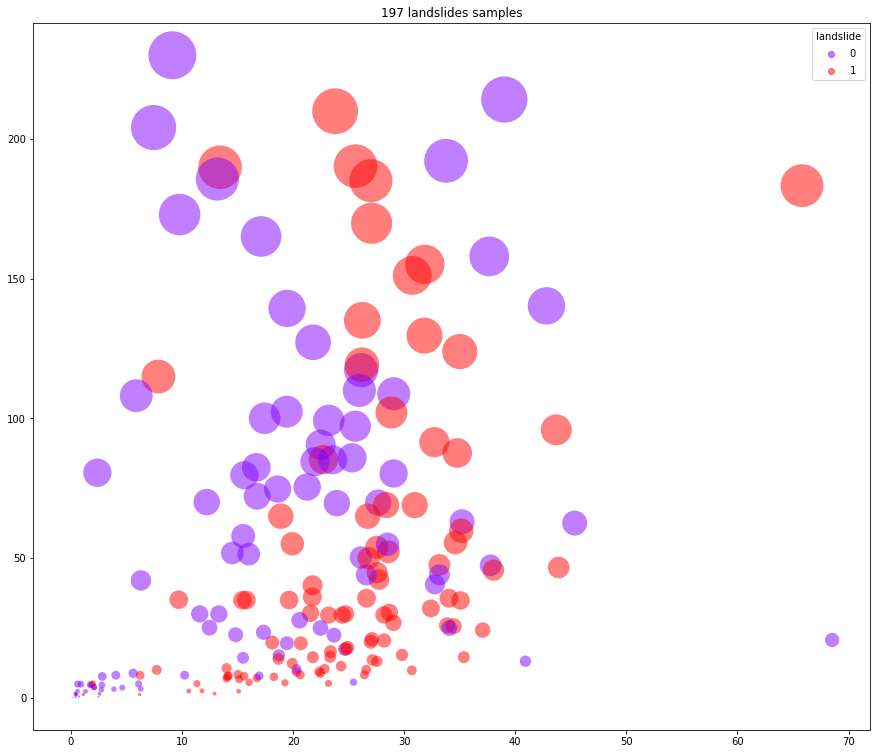

In [13]:
bubble_chart(dataset,"elevation","slope","elevation")

### Data Preparation
 - Based on the results of the feature importance analysis, all features were retained for training the ANN.
 - We addressed concerns about data leakage.

In [14]:
# According to previous analyses we notice some features are less relevant. 
# In case of random sample the less important features are: and the best accurancy with them is 999 and without is 999.

#random best features: twi, elevation, land_use
# 96.67% accu_test - 100.00% foi a melhor acurácia

# In case of non-occurance 200m far from occurence sample the less important features are: and the best accurancy with 
#them is 999 and without is 999.
#200m best features: 𝑠𝑙𝑜𝑝𝑒, 𝑡𝑤𝑖, and 𝑎𝑠𝑝𝑒𝑐𝑡.

# It is certified as the accuracy of the ANN is quite similar with or without them.
# However we decide to keep all of them.



dataset = dataset[['slope','aspect','elevation','land_use','lithology','twi','curvature','class']]

#dataset = dataset.drop('slope',axis=1)
#dataset = dataset.drop('aspect',axis=1)

dataset = dataset.drop('lithology',axis=1)
#dataset = dataset.drop('curvature',axis=1)

#dataset = dataset.drop('elevation',axis=1)
dataset = dataset.drop('land_use',axis=1)

dataset.head(5)

,slope,aspect,elevation,twi,curvature,class
0,33.860043,277.485138,25.912239,4.319798,-0.015372,1
1,0.727488,159.017288,0.418544,16.590740,-0.043386,0
2,1.114157,142.506317,1.117189,16.493561,-0.011949,0
3,20.309313,306.605927,9.144706,5.782696,-0.010980,1
4,43.904831,316.640686,46.628563,4.132583,-0.000184,1


In [15]:
X_train, X_test, X_val, y_train, y_test, y_val = dataPreparation(dataset)

In [16]:
print(len(X_train), 'train examples')
print(len(X_val), 'validation examples')
print(len(X_test), 'test examples')

95 train examples
42 validation examples
60 test examples


In [17]:
print(X_train.min(axis=0), X_test.max(axis=0))

[-1. -1. -1. -1. -1.] [1.08254853 1.03161732 1.1480696  0.81881985 2.3282485 ]


In [18]:
X = np.concatenate((X_train, X_val))
X = np.concatenate((X, X_test))

In [19]:
X.shape

(197, 5)

In [20]:
y = np.concatenate((y_train, y_val))
y = np.concatenate((y, y_test))

In [21]:
y.shape

(197, 1)

In [22]:
print(X.min(axis=0), X.max(axis=0))

[-1.00192557 -1.         -1.00014224 -1.16903795 -6.80518688] [1.08254853 1.03161732 1.1480696  1.         3.56467966]


__Compute the number of input and output features__

In [23]:
input_dim, output_dim = X_train.shape[1], y_train.shape[1]

### Custom neural network training

#### Hyperparameters tunning
- Brute force method
- Custom implementation for classes and functions

In [24]:
class hyperparametros: 
    def __init__(self, acuracia, camadas,neuronios,learning_rate,batch_size,dropout): 
        self.acuracia = acuracia 
        self.camadas = camadas
        self.neuronios = neuronios 
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.dropout = dropout

In [25]:
class ANN_accuracy: 
    def __init__(self, acuracia, _neuralNetwork): 
        self.acuracia = acuracia 
        self.ann = _neuralNetwork

In [26]:
#patience = early stopping
def setBestNeuralNetwork(hidden_layers,neurons, num_learning_rate, droput, input_dim, output_dim):
    nn = NeuralNetwork(cost_func = rna.binary_cross_entropy, learning_rate = num_learning_rate, momentum=0.1, patience=50) 

    #input layer
    nn.layers.append(Layer(input_dim=input_dim, output_dim=neurons,activation= rna.relu, weights_initializer=rna.glorot_normal))

    for num_hidden_layers in range(1,hidden_layers+1,1):
        #nn.layers.append(Layer(input_dim=neurons, output_dim=neurons,activation=rna.relu,reg_func=rna.l2_regularization,reg_strength=1e-2))
        nn.layers.append(Layer(input_dim=neurons, output_dim=neurons,activation=rna.relu,dropout_prob = droput,weights_initializer=rna.glorot_normal,biases_initializer=rna.glorot_normal))

    #output layer
    nn.layers.append(Layer(input_dim=neurons, output_dim=output_dim,activation=rna.sigmoid,weights_initializer=rna.glorot_normal))  

    return nn

In [27]:
# (batch_size) Implements the mini-batch that accelerates the training time, requires a mini-batch initialization method. 
#It is ideal for the batch size to be a multiple of the training dataset size, which is 128 here.
neurons = [7,8,12] 
# preciso encontrar uma forma de implementar a alteração do numero de neuronios na camada oculta variando 
# de n-2 até n+6
hidden_layers = [1,2,3]
learning_rate = [0.001,0.005,0.01]
batch_size = [0,4,8] 
dropout_rate = [0,0.1]
best_of_best_ANN = []
best_of_best_hyper = []

In [28]:
def setTestNeuralNetwork(hidden_layers,neurons, num_learning_rate, droput, input_dim, output_dim):
    #nn = NeuralNetwork(cost_func = rna.binary_cross_entropy, learning_rate = num_learning_rate, momentum=0.25, patience=50) 

    #camada de entrada
    print('\033[1m Input layer: {} inputs neurons  {} outputs neurons {} learning rate \033[0m'.format(input_dim, neurons,num_learning_rate))
    #nn.layers.append(Layer(input_dim=input_dim, output_dim=neurons,activation= rna.relu, weights_initializer=rna.glorot_normal))

    for num_hidden_layers in range(1,hidden_layers+1,1):
        print(' hidden layer {} neurons {} layers '.format(neurons,hidden_layers))
        #nn.layers.append(Layer(input_dim=neurons, output_dim=neurons,activation=rna.relu,reg_func=rna.l2_regularization,reg_strength=1e-2))
        #nn.layers.append(Layer(input_dim=neurons, output_dim=neurons,activation=rna.relu,dropout_prob = droput,weights_initializer=rna.glorot_normal))
    
    #nn.layers.append(Layer(input_dim=neurons, output_dim=output_dim,activation=rna.sigmoid,weights_initializer=rna.glorot_normal))  
    print('\033[1m {} last hidden layer neurons, {} output neurons \033[0m'.format(neurons,output_dim))

In [29]:
lst_hyperP = []
lst_ANN = []
for num_hidden_layers in hidden_layers:
    for num_neurons_layers in neurons:
        for num_learning_rate in learning_rate:
            for num_batch_size in batch_size:
                for prob_dropout in dropout_rate:
                    nn = setBestNeuralNetwork(num_hidden_layers,num_neurons_layers, num_learning_rate, prob_dropout, input_dim, output_dim)
                    
                    nn.fit(X_train, y_train, epochs=40000,batch_gen= rna.batch_shuffle, batch_size=num_batch_size, verbose=3000)
                
                    y_pred = nn.predict(X_val)
                    accu = 100*accuracy_score(y_val, y_pred > 0.5)
                    #accu = 100*roc_auc_score(y_val, y_pred > 0.5)
                    lst_hyperP.append(hyperparametros(accu,num_hidden_layers,num_neurons_layers,num_learning_rate,num_batch_size,prob_dropout) )
                    lst_ANN.append(ANN_accuracy(accu,nn))
                    print('To {} neurons, {} layer(s),  {} learning rate, {} batch size, {} dropout rate, we have: \033[1m Accuracy: {:.2f}% \033[0m'.format(num_neurons_layers,num_hidden_layers,num_learning_rate,num_batch_size,prob_dropout, accu))

epoch:    0/40000 loss_train: 0.92290823 + 0.00000000 = 0.92290823 loss_val = 0.92290823
epoch: 3000/40000 loss_train: 0.63976038 + 0.00000000 = 0.63976038 loss_val = 0.63976038
epoch: 6000/40000 loss_train: 0.59274081 + 0.00000000 = 0.59274081 loss_val = 0.59274081
epoch: 9000/40000 loss_train: 0.54412841 + 0.00000000 = 0.54412841 loss_val = 0.54412841
epoch: 12000/40000 loss_train: 0.50833692 + 0.00000000 = 0.50833692 loss_val = 0.50833692
epoch: 15000/40000 loss_train: 0.48839284 + 0.00000000 = 0.48839284 loss_val = 0.48839284
epoch: 18000/40000 loss_train: 0.47060882 + 0.00000000 = 0.47060882 loss_val = 0.47060882
epoch: 21000/40000 loss_train: 0.45898720 + 0.00000000 = 0.45898720 loss_val = 0.45898720
epoch: 24000/40000 loss_train: 0.45341536 + 0.00000000 = 0.45341536 loss_val = 0.45341536
epoch: 27000/40000 loss_train: 0.44776856 + 0.00000000 = 0.44776856 loss_val = 0.44776856
epoch: 30000/40000 loss_train: 0.43904089 + 0.00000000 = 0.43904089 loss_val = 0.43904089
epoch: 33000/4

KeyboardInterrupt: 

In [ ]:
best_hyper = max(lst_hyperP, key=lambda hyper: hyper.acuracia)
best_of_best_hyper.append(hyperparametros(best_hyper.acuracia,best_hyper.camadas,best_hyper.neuronios, best_hyper.learning_rate,best_hyper.batch_size,best_hyper.dropout) )
print('{:.2f}% was the best\033[1m accuracy\033[0m, having {} layer(s),{} neurons, {} of learning rate and {} of batch size as hyperparameters!'.format(best_hyper.acuracia,best_hyper.camadas,best_hyper.neuronios, best_hyper.learning_rate,best_hyper.batch_size))

In [ ]:
best_ann = max(lst_ANN, key=lambda hyper: hyper.acuracia)
best_of_best_ANN.append(ANN_accuracy(best_ann.acuracia,best_ann.ann))
print('{:.2f}% was the best\033[1m accuracy\033[0m, with ANN {} '.format(best_ann.acuracia,best_ann.ann))

In [ ]:
print('{} was the number of anns trained '.format(len(lst_ANN)))
lst_hyperP = []
lst_ANN = []

#### Assessment

https://medium.com/mdr-inc/from-sgd-to-adam-c9fce513c4bb

In [ ]:
best_of_best_ANN_Test = []
for best_RNA in best_of_best_ANN: 
  bestNN = best_RNA.ann
  yhat_probs = bestNN.predict(X_test)
  yhat_classes = (yhat_probs > 0.5)
  accu = 100*accuracy_score(y_test,yhat_classes)
  accMedia = (accu + best_RNA.acuracia) / 2
  print('{:.2f}% accu_test - {:.2f}% as the best\033[1m accurancy\033[0m, {:.2f} average acc {} ANN!'.format(accu,best_RNA.acuracia,accMedia,best_RNA.ann))
  accu = accMedia  
  best_of_best_ANN_Test.append(ANN_accuracy(accu,bestNN))

In [ ]:
for best_hyper in best_of_best_hyper: 
  print('{:.2f}% as the best \033[1m accurancy\033[0m, got with {} layers,{} neurons, {} of learning rate, {} batch size and {} dropout rate!'.format(best_hyper.acuracia,best_hyper.camadas,best_hyper.neuronios, best_hyper.learning_rate,best_hyper.batch_size,best_hyper.dropout))

In [ ]:
bestNN_Test = max(best_of_best_ANN_Test, key=lambda hyper: hyper.acuracia)
bestNN_Test = bestNN_Test.ann

In [ ]:
yhat_probs = bestNN_Test.predict(X_test)
yhat_classes = (yhat_probs > 0.5)
accu = 100*accuracy_score(y_test,yhat_classes)
print('{:.2f}%, test sample accurancy !'.format(accu))

Segunda abordagem - configura uma nova rede com os parametros obtidos da otimização por força bruta

In [ ]:
bestNN = max(best_of_best_ANN_Test, key=lambda hyper: hyper.acuracia)
bestNN = bestNN.ann

In [ ]:
bestHyper = max(best_of_best_hyper, key=lambda hyper: hyper.acuracia)
print('{:.2f}% as the best\033[1m accurancy\033[0m, got with {} layers, {} of learning rate, {} batch size and {} dropout rate!'.format(bestHyper.acuracia,bestHyper.camadas, bestHyper.learning_rate,bestHyper.batch_size,bestHyper.dropout))

In [ ]:
yhat_probs = bestNN.predict(X_test)
yhat_classes = (yhat_probs > 0.5)
accu = 100*accuracy_score(y_test,yhat_classes)
print('{:.2f}%, test sample accurancy !'.format(accu))

In [ ]:
#bstANN = bestNN
#bst_hyper = bstANN.hyper
#print('{:.2f}% as the best\033[1m accuracy\033[0m, got with {} layers, {} of learning rate, {} batch size and {} dropout rate!'.format(best_hyper.acuracia,best_hyper.camadas, best_hyper.learning_rate,best_hyper.batch_size,best_hyper.dropout))

#### Saving the best ANN architeture
 - Given the best set of hyperparameters, trained ANN is saved.

In [ ]:
if accu >= 85:
    print('{:.2f}%, excellent accuracy for test sample, ANN saved!'.format(accu))
    bestNN.save('bestANN\suscetibilidadeNN_guaruja.pkl')
else:
    print('Accuracy: {:.2f}% testing sample accuracy under .85!'.format(accu))

In [ ]:
y_pred = bestNN.predict(X_train)
print('Training sample accuracy: {:.2f}%'.format(100*accuracy_score(y_train, y_pred > 0.5)))

In [ ]:
y_pred = bestNN.predict(X_val)
print('Validation sample accuracy: {:.2f}%'.format(100*accuracy_score(y_val, y_pred > 0.5)))

In [ ]:
y_pred = bestNN.predict(X_test)
print('Test sample accuracy: {:.2f}%'.format(100*accuracy_score(y_test, y_pred > 0.5)))

In [ ]:
y_pred = bestNN.predict(X)
print('Overall sample accuracy: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))

__Upon achieving satisfactory accuracy with the test data, we save the appropriately trained network.__

In [ ]:
yhat_probs = bestNN.predict(X_train)
yhat_classes = (yhat_probs > 0.5)
accu = 100*accuracy_score(y_train, yhat_classes)
print('Acurácia: {:.2f}%'.format(accu))

In [ ]:
NetworkPerformance(y_train, yhat_probs)

In [ ]:
yhat_probs = bestNN.predict(X_test)
yhat_classes = (yhat_probs > 0.5)
accu = 100*accuracy_score(y_test,yhat_classes)
print('Acurácia: {:.2f}%'.format(accu))

In [ ]:
NetworkPerformance(y_test, yhat_probs)

In [ ]:
yhat_probs = bestNN.predict(X_val)
yhat_classes = (yhat_probs > 0.5)
accu = 100*accuracy_score(y_val,yhat_classes)
print('Accuracy: {:.2f}%'.format(accu))

In [ ]:
NetworkPerformance(y_val, yhat_probs)

In [ ]:
yhat_probs = bestNN.predict(X)
yhat_classes = (yhat_probs > 0.5)
accu = 100*accuracy_score(y,yhat_classes)
print('Accuracy: {:.2f}%'.format(accu))

In [ ]:
NetworkPerformance(y, yhat_probs)

In [ ]:
printAUROC(y,yhat_probs)

In [ ]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y,(yhat_probs > 0.5))

In [ ]:
import seaborn as sns

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Confusion Matrix\n\n')
ax.set_xlabel('Predicted occurrences\nAcurácia={:0.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))
ax.set_ylabel('Actual occurrences ')


## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [ ]:
output_proprietario = None
output_proprietario = dataset_original
output_proprietario['score'] = yhat_probs

In [ ]:
bubble_double_chart(output_proprietario,"slope","slope","elevation")

Agora considerar __RepeatedStratifiedKfold__ para avaliação da rede

ref. https://www.geeksforgeeks.org/stratified-k-fold-cross-validation/

ref. https://medium.com/@venkatasujit272/overview-of-cross-validation-3785d5414ece

In [ ]:
# Teste com objeto StratifiedKFold.
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
import statistics 

In [ ]:
#X = dataset.drop('class',axis=1)
#y= dataset['class']
#X = X.to_numpy()    #converts dataframe into array to be used at NN
#y = y.to_numpy()    #converts dataframe into array to be used at NN
#y = y.reshape(-1,1) #reorganiza o array em um array 1 x 1

#normalização do dataset
#minmax = MinMaxScaler(feature_range=(-1, 1))
#minmax = MinMaxScaler()
#X = minmax.fit_transform(X.astype(np.float64))
print(X.min(axis=0), X.max(axis=0))

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
lst_accu_stratified = []

rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=2,random_state=36851234)

print ('Numero de Splits_stratified de X: ',rskf.get_n_splits(X, y),'\n')

# Prin_stratifiedting the Train & Test Indices of splits
for train_index, test_index in rskf.split(X, y): 
    #print ("TRAIN:", train_index, "TEST:", test_index)
    X_train_stratified, X_test_stratified = X[train_index], X[test_index]
    y_train_stratified, y_test_stratified = y[train_index], y[test_index]
    print(X_train_stratified.shape, y_train_stratified.shape)
    
    yhat_probs = bestNN.predict(X_test_stratified)
    lst_accu_stratified.append(100*accuracy_score(y_test_stratified, yhat_probs > 0.5))

In [ ]:
print('Lista de acurácias obtidas:', lst_accu_stratified)
print('\nAcurácia máxima obtida:',
      max(lst_accu_stratified), '%')
print('\nAcurácia mínima:',
      min(lst_accu_stratified), '%')
print('\nAcurácia média:',
      statistics.mean(lst_accu_stratified), '%')
print('\nDesvio Padrão:', statistics.stdev(lst_accu_stratified))

Recupera modelo otimizado saldo anteriormente e o testa com diferentes conjuntos de dados.

In [ ]:
dataset

In [ ]:
y_pred = bestNN.predict(X)
yhat_classes = (y_pred > 0.5)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))
output_proprietario = None
output_proprietario = dataset_original
output_proprietario['score'] = y_pred
output_proprietario.to_csv('bestANN/mapaSuscetibilidade_proprietaria.csv', encoding="utf-8")

In [ ]:
NetworkPerformance(y, y_pred)

In [ ]:
output_proprietario

In [ ]:
from matplotlib import pyplot
ns_auc = roc_auc_score(y, y_pred)
# summarize scores
print('ROC AUC=%.3f' % (ns_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y, y_pred)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='ROC AUC')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

- ref. https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/
- ref. https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python

In [ ]:
bubble_double_chart(output_proprietario,"elevation","slope","elevation")

In [ ]:
dataSet = output_proprietario.sample(n = 50)
#dataSet = dataSet.drop('FID',axis=1)
#dataSet = dataSet.drop('X',axis=1)
#dataSet = dataSet.drop('Y',axis=1)
plotSwarmChart(dataSet)

In [ ]:
# perguntar para Ale como retornar os dados para ela, se em um csv com cada posição e as respectivas probabilidades?
# se for, basta incorporar essa variável y_pred à uma nova coluna do dataframe

In [ ]:
end = datetime.datetime.now()
print(end-start)
#quit()

### Keras neural network
__Problema de classificação, considerar as melhores práticas:__
- Ajuste dos hiperparametros
- Baseline para implementação customizada

ref. https://machinelearningmastery.com/data-preparation-without-data-leakage/


Agora, configura a rede com os melhores parâmetros

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
import tensorflow as tf

In [ ]:
print(len(X_train), 'train examples')
print(len(X_val), 'validation examples')
print(len(X_test), 'test examples')

In [ ]:
#{'num_hidden_layers': 1, 'num_units': 4, 'dropout_rate': 0.5, 'learning_rate': 0.004682800657889146}       

In [ ]:
#HyperParameters: {'num_hidden_layers': 2, 'num_units': 12, 'dropout_rate': 0.2821478566400208, 'learning_rate': 0.006549533067877217}
#conjunto de hyperparametros para o Guaruja 87% acuracia dados de teste.

In [ ]:
hypermodel = keras.Sequential()
hypermodel.add(Dense(24, activation='relu', input_dim=input_dim))

hypermodel.add(Dense(24, activation='relu'))
hypermodel.add(Dropout(0.43719886068153724))

#hypermodel.add(Dense(24, activation='relu'))
#hypermodel.add(Dropout(0.5))
#hypermodel.add(Dense(24, activation='relu'))
#hypermodel.add(Dropout(0.5))
#hypermodel.add(Dense(24, activation='relu'))
#hypermodel.add(Dropout(0.5))
#hypermodel.add(Dense(24, activation='relu'))
#hypermodel.add(Dropout(0.5))
#hypermodel.add(Dense(24, activation='relu'))
#hypermodel.add(Dropout(0.5))
#hypermodel.add(Dense(24, activation='relu'))
#hypermodel.add(Dropout(0.5))
#hypermodel.add(Dense(24, activation='relu'))
#hypermodel.add(Dropout(0.5))

hypermodel.add(Dense(1, activation='sigmoid'))
learning_rate= 0.01
myOptimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
hypermodel.compile(optimizer=myOptimizer, loss="binary_crossentropy", metrics=['accuracy'])

In [ ]:
#model.fit(X_train, y_train, epochs=100, batch_size=5)
history           = hypermodel.fit(X_train, y_train, epochs=500, batch_size=5)
val_acc_per_epoch = history.history['accuracy']
best_epoch        = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1

In [ ]:
print('Best epoch: %d' % (best_epoch,))

In [ ]:
# avaliação via keras
_, accuracy = hypermodel.evaluate(X_test, y_test)
print('Accuracy: %.2f' % (accuracy*100))

In [ ]:
# Retrain the model
history = hypermodel.fit(X_train, y_train, epochs=best_epoch)

In [ ]:
# avaliação via keras
_, accuracy = hypermodel.evaluate(X_test, y_test)
print('Accuracy: %.2f' % (accuracy*100))

In [ ]:
import tensorflow as tf
# rankdir='LR' is used to make the graph horizontal.
tf.keras.utils.plot_model(hypermodel, show_shapes=True, rankdir="LR")

In [ ]:
if accuracy >= .80:
    print('ótima acurácia, rede salva!')
    hypermodel.save('bestANN\suscetibilidadeKeras_guaruja.pkl')
else:
    print('acurácia abaixo de .85')

#### Assessment

In [ ]:
#X = dataset.drop('class',axis=1)
#y = dataset['class']
#X = X.to_numpy()    #converts dataframe into array to be used at NN
#y = y.to_numpy()    #converts dataframe into array to be used at NN
#y = y.reshape(-1,1) #reorganiza o array em um array 1 x 1

#normalização do dataset
#minmax = MinMaxScaler(feature_range=(-1, 1))
#X = minmax.fit_transform(X.astype(np.float64))
#print(X.min(axis=0), X.max(axis=0))

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
lst_accu_stratified = []

rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=2,random_state=36851234)

print ('Numero de Splits de X: ',rskf.get_n_splits(X, y),'\n')

# Printing the Train & Test Indices of splits
for train_index, test_index in rskf.split(X, y): 
    #print ("TRAIN:", train_index, "TEST:", test_index)
    X_train_stratified_keras, X_test_stratified_keras = X[train_index], X[test_index]
    y_train_stratified_keras, y_test_stratified_keras = y[train_index], y[test_index]
    #print('novo dataset')
    #print(X_train_stratified_keras.shape, y_train_stratified_keras.shape)
    
    yhat_probs = hypermodel.predict(X_test_stratified_keras)
    lst_accu_stratified.append(100*accuracy_score(y_test_stratified_keras, yhat_probs > 0.5))

In [ ]:
print('Lista de acurácias obtidas:', lst_accu_stratified)
print('\nAcurácia máxima obtida:',
      max(lst_accu_stratified), '%')
print('\nAcurácia mínima:',
      min(lst_accu_stratified), '%')
print('\nAcurácia média:',
      statistics.mean(lst_accu_stratified), '%')
print('\nDesvio Padrão:', statistics.stdev(lst_accu_stratified))

In [ ]:
y_pred = hypermodel.predict(X_test)
#print('Predições:', y_pred, sep='\n')
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y_test, y_pred > 0.5)))

In [ ]:
y_pred = hypermodel.predict(X_train)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y_train, y_pred > 0.5)))

In [ ]:
y_pred = hypermodel.predict(X_val)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y_val, y_pred > 0.5)))

In [ ]:
y_pred = hypermodel.predict(X)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))

In [ ]:
output_keras = None
output_keras = dataset_original
output_keras['score'] = y_pred
output_keras.to_csv('bestANN/mapaSuscetibilidade_keras.csv', encoding="utf-8")
output_keras

In [ ]:
NetworkPerformance(y, y_pred)

In [ ]:
ns_auc = roc_auc_score(y, y_pred)
# summarize scores
print('ROC AUC=%.3f' % (ns_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y, y_pred)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='ROC AUC')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [ ]:
bubble_double_chart(output_proprietario,"elevation","slope","elevation")

In [ ]:
dataSet = output_keras.sample(n = 50)
#dataSet = dataSet.drop('FID',axis=1)
#dataSet = dataSet.drop('X',axis=1)
#dataSet = dataSet.drop('Y',axis=1)
plotSwarmChart(dataSet)

In [ ]:
end = datetime.datetime.now()
print(end-start)

## References
- ref.1: https://www.tensorflow.org/tutorials/structured_data/preprocessing_layers
- ref.2: https://www.tensorflow.org/tutorials/structured_data/feature_columns
- ref.3: https://realpython.com/train-test-split-python-data/
- ref.4: https://machinelearningmastery.com/data-preparation-without-data-leakage/
- ref.5: https://towardsdatascience.com/data-leakage-in-machine-learning-10bdd3eec742
- ref.6: https://analyticsindiamag.com/what-is-data-leakage-in-ml-why-should-you-be-concerned/
- ref.7: https://www.section.io/engineering-education/data-leakage/
- ref.8: https://medium.com/analytics-vidhya/overfitting-vs-data-leakage-in-machine-learning-ec59baa603e1
- ref.9: https://www.analyticsvidhya.com/blog/2020/06/auc-roc-curve-machine-learning/

Comparando predição com rede do keras
- ref. https://machinelearningmastery.com/tutorial-first-neural-network-python-keras/

Tunning neural netowrks
- ref. http://karpathy.github.io/2019/04/25/recipe/

Sobre as métricas
- ref. https://neptune.ai/blog/f1-score-accuracy-roc-auc-pr-auc